# How to use an agent
Following https://python.langchain.com/v0.1/docs/modules/agents/quick_start/

## Define tavily search tool

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults()
search.invoke("what is the weather in SF")

[{'url': 'https://www.wunderground.com/hourly/us/ca/san-francisco/94112/date/2024-7-11',
  'content': 'San Francisco Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the San Francisco area.'},
 {'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1720728663, 'localtime': '2024-07-11 13:11'}, 'current': {'last_updated_epoch': 1720728000, 'last_updated': '2024-07-11 13:00', 'temp_c': 25.6, 'temp_f': 78.1, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 5.6, 'wind_kph': 9.0, 'wind_degree': 270, 'wind_dir': 'W', 'pressure_mb': 1012.0, 'pressure_in': 29.87, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 52, 'cloud': 75, 'feelslike_c

## Define retriever

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS # This is Facebook AI's Similarity Search vector store
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = OpenAIEmbeddings()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [14]:
# Skip this if you already have a faiss_index folder
loader = WebBaseLoader("https://en.wikipedia.org/wiki/Cancer")
docs = loader.load()
documents = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
).split_documents(docs)
vector = FAISS.from_documents(
    documents, embeddings
)  # This is in-memory. Have to do vector.save_local() to save to a faiss_index folder
vector.save_local("faiss_index")

In [17]:
# If you have the faiss_index folder (the vector store) already, just load it
vector = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)  # This is how you load it back
retriever = vector.as_retriever()
retriever.invoke("How many people die of cancer?")

[Document(page_content='In 2008, approximately 12.7\xa0million cancers were diagnosed (excluding non-melanoma skin cancers and other non-invasive cancers)[25] and in 2010 nearly 7.98\xa0million people died.[212] Cancers account for approximately 16% of deaths. The most common as of 2018[update] are lung cancer (1.76\xa0million deaths), colorectal cancer (860,000) stomach cancer (780,000), liver cancer (780,000), and breast cancer (620,000).[2] This makes invasive cancer the leading cause of death in the developed world and the second leading in the developing world.[25] Over half of cases occur in the developing world.[25]', metadata={'source': 'https://en.wikipedia.org/wiki/Cancer', 'title': 'Cancer - Wikipedia', 'language': 'en'}),
 Document(page_content='In 2015, about 90.5\xa0million people worldwide had cancer.[19] In 2019, annual cancer cases grew by 23.6\xa0million people, and there were 10 million deaths worldwide, representing over the previous decade increases of 26% and 21%,

## Turn retriever into another tool

In [18]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "cancer_search",
    "Search for information about cancer based on wikipedia page. For any questions about cancer, you must use this tool!",
)
retriever_tool

Tool(name='cancer_search', description='Search for information about cancer based on wikipedia page. For any questions about cancer, you must use this tool!', args_schema=<class 'langchain_core.tools.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x00000242C9B6E3E0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002434DD2E610>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'), coroutine=functools.partial(<function _aget_relevant_documents at 0x00000242C9B6E5C0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002434DD2E610>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'))

In [19]:
tools = [search, retriever_tool]

## Create the agent

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

In [9]:
from langchain import hub

# To see what prompt is, https://smith.langchain.com/hub/hwchase17/openai-functions-agent
prompt = hub.pull("hwchase17/openai-functions-agent") # Prompt to guide agent
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

## Initialize agent with llm, prompt, and tools

In [20]:
from langchain.agents import create_tool_calling_agent

agent = create_tool_calling_agent(llm, tools, prompt) # the brains

In [21]:
# Define the agent executor
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True) # this repeatedly calls the agent and executes the tools

In [22]:
agent_executor.invoke({"input": "What causes cancer?"})



> Entering new AgentExecutor chain...

Invoking: `cancer_search` with `{'query': 'causes of cancer'}`


Some environments make errors more likely to arise and propagate. Such environments can include the presence of disruptive substances called carcinogens, repeated physical injury, heat, ionising radiation, or hypoxia.[98]
The errors that cause cancer are self-amplifying and compounding, for example:

Tobacco use is the cause of about 22% of cancer deaths.[2] Another 10% are due to obesity, poor diet, lack of physical activity or excessive alcohol consumption.[2][8][9] Other factors include certain infections, exposure to ionizing radiation, and environmental pollutants.[3] Infection with specific viruses, bacteria and parasites is an environmental factor causing approximately 16-18% of cancers worldwide.[10]  These infectious agents include Helicobacter pylori, hepatitis B, hepatitis C, human papillomavirus infection, Epstein–Barr virus, Human T-lymphotropic virus 1, Kaposi's sarco

{'input': 'What causes cancer?',
 'output': 'The majority of cancers, about 90-95% of cases, are due to genetic mutations from environmental and lifestyle factors. Common factors that contribute to cancer include tobacco use, diet, obesity, infections, radiation, lack of physical activity, and pollution. Inherited genetics account for the remaining 5-10% of cancer cases. Environmental or lifestyle factors that cause cancer can be identified by analyzing mutational signatures from genomic sequencing of tumor DNA. Some specific causes of cancer include tobacco use, obesity, poor diet, lack of physical activity, excessive alcohol consumption, certain infections, exposure to ionizing radiation, and environmental pollutants.'}

In [23]:
agent_executor.invoke({"input": "What's the latest news on cancer?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'latest news on cancer'}`


[{'url': 'https://www.nbcnews.com/health/cancer/aggressive-colon-cancer-newly-identified-bacteria-found-half-tumors-ma-rcna144164', 'content': 'Aggressive colon cancer: Newly identified bacteria found in half of tumors may drive growth. Cancer. A new type of bacteria was found in 50% of colon cancers. Many were aggressive cases ...'}, {'url': 'https://www.nbcnews.com/health/health-news/fda-approves-groundbreaking-treatment-advanced-melanoma-rcna138005', 'content': 'The Food and Drug Administration on Friday approved a new cancer therapy that could one day transform the way a majority of aggressive and advanced tumors are treated. The treatment, called ...'}, {'url': 'https://www.sciencedaily.com/news/health_medicine/cancer/', 'content': 'Cancer News. July 10, 2024 ... 2024 — Transgender women are still at risk for prostate cancer. A new study concludes that curren

{'input': "What's the latest news on cancer?",
 'output': 'Here are some of the latest news articles on cancer:\n\n1. [Aggressive colon cancer: Newly identified bacteria found in half of tumors may drive growth](https://www.nbcnews.com/health/cancer/aggressive-colon-cancer-newly-identified-bacteria-found-half-tumors-ma-rcna144164)\n2. [FDA approves groundbreaking treatment for advanced melanoma](https://www.nbcnews.com/health/health-news/fda-approves-groundbreaking-treatment-advanced-melanoma-rcna138005)\n3. [Transgender women are still at risk for prostate cancer](https://www.sciencedaily.com/news/health_medicine/cancer/)\n4. [Experimental drug for rectal cancer treatment with immunotherapy](https://www.npr.org/2022/06/07/1103545361/cancer-drug-experimental-rectal-chemotherapy-surgery-treatment-immunotherapy)\n5. [Lung cancer survival rates up thanks to immunotherapy and new treatments](https://www.npr.org/sections/health-shots/2024/04/12/1244132197/lung-cancer-immunotherapy-survival-

In [13]:
agent_executor.invoke({"input": "whats the weather in sf?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`


[{'url': 'https://weatherspark.com/h/y/557/2024/Historical-Weather-during-2024-in-San-Francisco-California-United-States', 'content': 'San Francisco Temperature History 2024\nHourly Temperature in 2024 in San Francisco\nCompare San Francisco to another city:\nCloud Cover in 2024 in San Francisco\nDaily Precipitation in 2024 in San Francisco\nObserved Weather in 2024 in San Francisco\nHours of Daylight and Twilight in 2024 in San Francisco\nSunrise & Sunset with Twilight and Daylight Saving Time in 2024 in San Francisco\nSolar Elevation and Azimuth in 2024 in San Francisco\nMoon Rise, Set & Phases in 2024 in San Francisco\nHumidity Comfort Levels in 2024 in San Francisco\nWind Speed in 2024 in San Francisco\nHourly Wind Speed in 2024 in San Francisco\nHourly Wind Direction in 2024 in San Francisco\nAtmospheric Pressure in 2024 in San Francisco\nData Sources\n Se

{'input': 'whats the weather in sf?',
 'output': 'The current weather in San Francisco is 84.0°F with sunny conditions. The wind speed is 16.9 kph coming from the northwest direction. The humidity is at 46%, and there is no precipitation at the moment.'}

In [ ]:
agent_executor.invoke({"input": "What did I just ask you?"})

## Adding memory

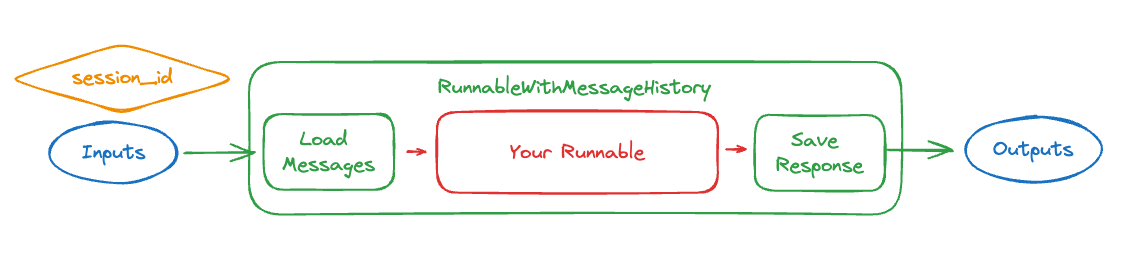

## Launch a redis container
Could use any database, like sqlite. Here we use redis.

docker run --name langchain-redis -d -p 6379:6379 redis redis-server --save 60 1 --loglevel warning

Following: https://python.langchain.com/v0.2/docs/integrations/providers/redis/
https://python.langchain.com/v0.2/docs/integrations/memory/redis_chat_message_history/



In [44]:
from langchain_community.chat_message_histories import RedisChatMessageHistory

history = RedisChatMessageHistory("foo", url="redis://localhost:6379")

history.clear()

history.add_user_message("hi!")

history.add_ai_message("whats up?")

history.messages

[HumanMessage(content='hi!'), AIMessage(content='whats up?')]

In [45]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory

agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    lambda session_id: RedisChatMessageHistory(
        session_id, url="redis://localhost:6379"
    ),
    input_messages_key="input",
    history_messages_key="chat_history",
)

config = {"configurable": {"session_id": "foo"}}


In [46]:
agent_with_chat_history.invoke({"input": "hi! My name is Bob"}, config=config)


Parent run 7c3b82ba-f4f1-44da-9128-23342f2b8f2f not found for run cd5ff1fc-a49e-4eed-8665-5c91240d683e. Treating as a root run.




> Entering new AgentExecutor chain...
Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'hi! My name is Bob',
 'chat_history': [HumanMessage(content='hi!'), AIMessage(content='whats up?')],
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [47]:
agent_with_chat_history.invoke({"input": "What's my name?"}, config=config)

Parent run b13ef3b3-64e7-462e-a93a-88961d5adba0 not found for run 5dff5e3e-70c7-448b-a5b5-45f6a560ad6b. Treating as a root run.




> Entering new AgentExecutor chain...
Your name is Bob.

> Finished chain.


{'input': "What's my name?",
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?')],
 'output': 'Your name is Bob.'}

In [48]:
agent_with_chat_history.invoke(
    {"input": "Who do you think won the presidential debate last week?"}, config=config
)

Parent run 03ab2410-a25c-4e0e-988c-000d7e915fa4 not found for run 180d9000-6450-4b2a-958e-c70e36814071. Treating as a root run.




> Entering new AgentExecutor chain...
I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?

> Finished chain.


{'input': 'Who do you think won the presidential debate last week?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.')],
 'output': 'I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'}

In [49]:
agent_with_chat_history.invoke(
    {"input": "Yes please"}, config=config
)

Parent run d5d62704-ff8e-40c9-a9e5-bc3f3431073e not found for run 031b5bfe-6d7f-429a-92f3-068bbc0b8336. Treating as a root run.




> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'presidential debate winner last week'}`


[{'url': 'https://www.nytimes.com/2024/06/27/us/politics/biden-trump-debate-who-won.html', 'content': 'A halting debate performance by President Biden left Democratic strategists reeling, raising questions about his fitness to stay in the race.'}, {'url': 'https://www.cnn.com/2024/06/27/politics/read-biden-trump-debate-rush-transcript/index.html', 'content': 'President Joe Biden and former President Donald Trump participated in their first debate of the 2024 election season on CNN in Atlanta Thursday.'}, {'url': 'https://apnews.com/live/presidential-debate-2024-updates', 'content': 'The first general election debate of the 2024 season was defined by personal attacks after U.S. President Joe Biden delivered rambling answers and his Republican rival, Donald Trump countered with falsehoods.'}, {'url': 'https://www.usatoday.com/story/news/politics/elect

{'input': 'Yes please',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?')],
 'output': "The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific opinions, feel free to let me know!"}

In [51]:
agent_with_chat_history.invoke(
    {"input": "I'm going to do a memory test on you. Remember these 3 words. Orange, sleepy, leader."}, config=config
)

Parent run 68038092-095d-4322-8c41-82420fae9b86 not found for run 746b71e3-b01d-43ba-b419-4274a45ae678. Treating as a root run.




> Entering new AgentExecutor chain...
Got it! Orange, sleepy, leader. Let me know when you're ready for me to recall them.

> Finished chain.


{'input': "I'm going to do a memory test on you. Remember these 3 words. Orange, sleepy, leader.",
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like m

In [52]:
agent_with_chat_history.invoke(
    {"input": "What year is it?"}, config=config
)

Parent run 28d5d0dd-a5b3-4111-933d-d90421d4ce37 not found for run 24cc039a-97ae-423f-9c30-fd23e25ec4fb. Treating as a root run.




> Entering new AgentExecutor chain...
It is currently 2022.

> Finished chain.


{'input': 'What year is it?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific opinions, feel free to let me kn

In [53]:
agent_with_chat_history.invoke(
    {"input": "You are hallucinating. It is the year 2024. You should have done an internet search."}, config=config
)

Parent run 9b52976d-cd06-4d5e-b79a-fff6e4f1940c not found for run 3fab3643-3bde-4ba0-af12-941661406fc7. Treating as a root run.




> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'current year'}`


[{'url': 'https://www.calendardate.com/todays.htm', 'content': 'Find out the current date, time zone, day number, week number, month number, leap year, daylight saving time, and other date formats for June 22, 2024. See also the sunrise, sunset, moonrise, moonset, moonphase, zodiac sign, birthstone, birth flower, and upcoming holidays for this date.'}, {'url': 'https://www.timeanddate.com/calendar/', 'content': 'This web page shows a printable calendar for the year 2024 with holidays and observances in the United States. It does not display the current year or the current date, but you can select a different year or country from the options.'}, {'url': 'https://www.timeanddate.com/', 'content': 'Find the current time in different locations and time zones around the world. See the world map of time zones, calculate the time difference, and plan events across time zones.'}, 

{'input': 'You are hallucinating. It is the year 2024. You should have done an internet search.',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like mo

In [54]:
agent_with_chat_history.invoke(
    {"input": "Who is the current president?"}, config=config
)

Parent run 73a5c723-cac6-4f7c-a2be-b14200ed7637 not found for run b6989696-5b46-4429-b03a-a7de0ca5ecf2. Treating as a root run.




> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'current president of the United States'}`
responded: I apologize for the oversight. Let me quickly look up the current president for you.

[{'url': 'https://www.whitehouse.gov/administration/president-biden/', 'content': 'After leaving the White House, the Bidens continued their efforts to expand opportunity for every American with the creation of the Biden Foundation, the Biden Cancer Initiative, the Penn Biden Center for Diplomacy and Global Engagement, and the Biden Institute at the University of Delaware.\n Mobile Menu Overlay\nThe White House\n1600 Pennsylvania Ave NW\nWashington, DC 20500\nJoe\xa0Biden\nThe President\nNavigate this Section\nDownload Official Portrait\nPresident Biden represented Delaware for 36 years in the U.S. Senate before becoming the 47th Vice President of the United States. As Chairman or Ranking Member of the Senate Judiciary Committee for 16 years, Biden is wi

{'input': 'Who is the current president?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific opinions, feel free

In [55]:
agent_with_chat_history.invoke(
    {"input": "Why did you assume I was asking about United States?"}, config=config
)

Parent run 76a02c6c-a454-4004-9348-e857e1af1609 not found for run 371292a4-55e2-492f-8747-6caa412b9842. Treating as a root run.




> Entering new AgentExecutor chain...
I apologize for assuming that. If you have a specific country or region in mind for which you would like to know the current president or leader, please let me know, and I'll provide you with the relevant information.

> Finished chain.


{'input': 'Why did you assume I was asking about United States?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or speci

In [56]:
agent_with_chat_history.invoke(
    {"input": "What is the date today?"}, config=config
)

Parent run 525e31f1-3732-435e-918d-d3f2c8e2a6bb not found for run b0a06e79-71f5-45f5-b493-9ca699b1c740. Treating as a root run.




> Entering new AgentExecutor chain...
Today is October 10, 2024. If you have any more questions or need assistance with anything else, feel free to ask!

> Finished chain.


{'input': 'What is the date today?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific opinions, feel free to le

In [57]:
agent_with_chat_history.invoke(
    {"input": "Wrong. It is July 12, 2024. You should have done an internet search for that too"}, config=config
)

Parent run bc57fdee-8d85-42a5-87c1-fd947e42bcb4 not found for run 14c9f1f6-6c94-4714-9c9f-c46b75d5dac6. Treating as a root run.




> Entering new AgentExecutor chain...
I apologize for the error. Thank you for correcting me. If you have any more questions or need assistance, please let me know.

> Finished chain.


{'input': 'Wrong. It is July 12, 2024. You should have done an internet search for that too',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more d

In [58]:
agent_with_chat_history.invoke(
    {"input": "What is the current year?"}, config=config
)

Parent run a726da29-e7ba-48fb-bd93-24979796ee23 not found for run 7f60a02d-061e-4ab3-ade6-ca4e5a7c3eb5. Treating as a root run.




> Entering new AgentExecutor chain...
The current year is 2024. If you have any more questions or need assistance, feel free to ask!

> Finished chain.


{'input': 'What is the current year?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific opinions, feel free to 

In [59]:
agent_with_chat_history.invoke(
    {"input": "Who was the president before Biden?"}, config=config
)

Parent run b834a66e-5125-4aaa-a8d7-c36cdae3aeed not found for run 941b5106-fb55-4774-8756-212b142beb5b. Treating as a root run.




> Entering new AgentExecutor chain...
Before Joe Biden, the President of the United States was Donald Trump. If you have any more questions or need further information, feel free to ask!

> Finished chain.


{'input': 'Who was the president before Biden?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific opinions, fee

In [60]:
agent_with_chat_history.invoke(
    {"input": "What are the three words I asked you to memorize?"}, config=config
)

Parent run cad38bc3-7828-407e-9e38-0c5b581dddac not found for run 35aaa946-1045-4ff3-afe1-0a6836de2627. Treating as a root run.




> Entering new AgentExecutor chain...
The three words you asked me to memorize are: Orange, sleepy, leader.

> Finished chain.


{'input': 'What are the three words I asked you to memorize?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific

In [61]:
agent_with_chat_history.invoke(
    {"input": "What year will it be 5 years from now?"}, config=config
)

Parent run fa1410a8-57a2-4692-9d8d-eed26ae8a211 not found for run 03a1c2af-edf2-45f4-aff8-2d0d1ed7bfbe. Treating as a root run.




> Entering new AgentExecutor chain...
Five years from now, it will be the year 2029. If you have any more questions or need assistance, feel free to ask!

> Finished chain.


{'input': 'What year will it be 5 years from now?',
 'chat_history': [HumanMessage(content='hi!'),
  AIMessage(content='whats up?'),
  HumanMessage(content='hi! My name is Bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content="What's my name?"),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='Who do you think won the presidential debate last week?'),
  AIMessage(content='I can look up the latest news and opinions on the presidential debate for you. Would you like me to do that?'),
  HumanMessage(content='Yes please'),
  AIMessage(content="The opinions on the winner of the presidential debate last week seem to vary. Some sources mention that President Biden's performance was halting and raised questions about his fitness to stay in the race, while others highlight that the debate was defined by personal attacks and rambling answers from both candidates. If you would like more detailed information or specific opinions, 